# Fine-Tuning a Generative Pretrained Transformer (`GPT`)

1. Install required libraries.

In [ ]:
!pip install transformers datasets sentencepiece codecarbon -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 51.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.6/519.6 kB 41.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 70.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.8/179.8 kB 20.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.0/302.0 kB 29.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 91.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 74.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 13.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 23.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 16.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.4/66.4 kB 7.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.1/53.1 kB 6.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

2. Load the data from the hub.

In [ ]:
import os
import pandas as pd
from datasets import load_dataset

project = "Aira-2-1B1"

os.makedirs(project, exist_ok=True)

dataset = load_dataset("nicholasKluge/instruct-aira-dataset", split="english")

df = dataset.to_pandas()

display(df)

Extracting data files:   0%|          | 0/2 [00:00<?, ?it/s]

Generating english split:   0%|          | 0/41815 [00:00<?, ? examples/s]

Generating portuguese split:   0%|          | 0/41815 [00:00<?, ? examples/s]

prompt  \
0         Why can camels survive for long without water?   
1                            Why mobile is bad for human   
2                                     What is a polygon?   
3                                How do I start running?   
4      Which episodes of season four of Game of Thron...   
...                                                  ...   
41810                            What can I call you by?   
41811                   What's your identification name?   
41812                               What are you called?   
41813                     How do you introduce yourself?   
41814              What should I say when I address you?   

                                              completion  
0      Camels can survive for long periods without wa...  
1      Mobile phones as technological devices have be...  
2      A polygon is a two-dimensional geometric figur...  
3      Starting a running routine can be a great way ...  
4      Michelle MacLaren directed two episodes in Sea...  
...                                                  ...  
41810  You can call me Aira. How may I assist you today?  
41811  As an artificial intelligence, I do not have a...  
41812  Hello! I am called Aira. How can I assist you ...  
41813  Hello! I am Aira, your helpful, respectful, an...  
41814  When addressing me, you can simply call me Air...  

[41815 rows x 2 columns]

3. Load `LlamaTokenizer` and add the chosen special tokens (`'<|startofinstruction|>', '<|endofinstruction|>', '<|endofcompletion|>','<|pad|>'`)
4. Create demonstrations by prepending the special tokens.
5. Calculate the maximum length (in tokens) that the demonstrations have.

In [ ]:
from transformers import LlamaTokenizer

model = "PY007/TinyLlama-1.1B-intermediate-step-480k-1T"
model_size = "1.1B"

tokenizer = LlamaTokenizer.from_pretrained(model,
                                          bos_token='<|startofinstruction|>',
                                          sep_token = '<|endofinstruction|>',
                                          eos_token='<|endofcompletion|>',
                                          pad_token='<|pad|>')

df['demonstrations'] = tokenizer.bos_token + df['prompt'] + tokenizer.sep_token + df['completion'] + tokenizer.eos_token

df['length'] = df['demonstrations'].apply(lambda x: len(tokenizer.encode(x)))

print("Total number of demonstrations: ", len(df))
print(f"The longest demonstration is {df['length'].max()} tokens long.")

Total number of demonstrations:  41815
The longest demonstration is 536 tokens long.


6. Create the Dataset class.

In [ ]:
import torch
from torch.utils.data import Dataset

max_length = 540

class InstructDataset(Dataset):

  def __init__(self, demonstrations, tokenizer, max_length=max_length):

    self.tokenizer = tokenizer
    self.input_ids = []
    self.attn_masks = []

    for demo in demonstrations:

      encodings_dict = tokenizer(demo,
                                 truncation=True,
                                 max_length=max_length,
                                 padding="max_length")

      self.input_ids.append(torch.tensor(encodings_dict['input_ids']))
      self.attn_masks.append(torch.tensor(encodings_dict['attention_mask']))

  def __len__(self):
    return len(self.input_ids)

  def __getitem__(self, idx):
    return self.input_ids[idx], self.attn_masks[idx]

dataset = InstructDataset(df.demonstrations.to_list(), tokenizer, max_length=max_length)

7. Create the `DataLoaders` and specify the `batch_size`.

In [ ]:
from torch.utils.data import DataLoader, RandomSampler

dataloader = DataLoader(
            dataset,
            sampler=RandomSampler(dataset),
            batch_size=4
        )

8. Load the base model (`LlamaForCausalLM`).

In [ ]:
from transformers import LlamaForCausalLM, LlamaConfig

configuration = LlamaConfig.from_pretrained(model, output_hidden_states=False)

model = LlamaForCausalLM.from_pretrained(model, config=configuration)
model.resize_token_embeddings(len(tokenizer))

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model.to(device)

LlamaForCausalLM(
  (model): LlamaModel(
    (embed_tokens): Embedding(32004, 2048)
    (layers): ModuleList(
      (0-21): 22 x LlamaDecoderLayer(
        (self_attn): LlamaAttention(
          (q_proj): Linear(in_features=2048, out_features=2048, bias=False)
          (k_proj): Linear(in_features=2048, out_features=256, bias=False)
          (v_proj): Linear(in_features=2048, out_features=256, bias=False)
          (o_proj): Linear(in_features=2048, out_features=2048, bias=False)
          (rotary_emb): LlamaRotaryEmbedding()
        )
        (mlp): LlamaMLP(
          (gate_proj): Linear(in_features=2048, out_features=5632, bias=False)
          (up_proj): Linear(in_features=2048, out_features=5632, bias=False)
          (down_proj): Linear(in_features=5632, out_features=2048, bias=False)
          (act_fn): SiLUActivation()
        )
        (input_layernorm): LlamaRMSNorm()
        (post_attention_layernorm): LlamaRMSNorm()
      )
    )
    (norm): LlamaRMSNorm()
  )
  (lm_head)

9. Set the training hyperparameters.

In [ ]:
from transformers import get_linear_schedule_with_warmup

# training rounds
epochs = 3

# steps at the start of training that are ignored
warmup_steps = 1e2

# sample the model to test the output
sample_every = 400

optimizer = torch.optim.AdamW(model.parameters(), lr = 5e-4, eps = 1e-8)

# total steps = number of batches * number of epochs
total_steps = len(dataloader) * epochs

# create the learning rate scheduler
scheduler = get_linear_schedule_with_warmup(optimizer,
                                            num_warmup_steps = warmup_steps,
                                            num_training_steps = total_steps)

10. Training/Validation loop. Track the carbon emissions of your work by using `codecarbon`. 🌱

In [ ]:
from codecarbon import EmissionsTracker
import tqdm


output_dir = f'/content/{project}'

tracker = EmissionsTracker(
    project_name="Aira_emissions",
    log_level="critical",
    output_dir=output_dir,
    output_file="Aira_emissions.csv",
)

training_stats = []

tracker.start()
for epoch_i in range(0, epochs):

    print(f'\nBeginning epoch {epoch_i + 1} of {epochs}\n')

    total_train_loss = 0

    model.train()

    for step, batch in enumerate(tqdm.tqdm(dataloader)):

        b_input_ids = batch[0].to(device)
        b_labels = batch[0].to(device)
        b_masks = batch[1].to(device)

        model.zero_grad()

        outputs = model(b_input_ids,
                        labels=b_labels,
                        attention_mask = b_masks)

        loss = outputs[0]

        batch_loss = loss.item()
        total_train_loss += batch_loss

        if step % sample_every == 0 and not step == 0:

            print(f'\nBatch {step} of {len(dataloader)}. Loss:{batch_loss}.\n')

            model.eval()

            inputs = tokenizer(tokenizer.bos_token + df.prompt.sample().iloc[0] + tokenizer.eos_token, return_tensors="pt").to(device)

            sample_outputs = model.generate(**inputs,
                                bos_token_id=tokenizer.bos_token_id,
                                pad_token_id=tokenizer.pad_token_id,
                                eos_token_id=tokenizer.eos_token_id,
                                do_sample=True,
                                top_k=50,
                                max_length = 200,
                                top_p=0.95,
                                num_return_sequences=1)

            for i, sample_output in enumerate(sample_outputs):
                  print(f'\nExample output: {tokenizer.decode(sample_output, skip_special_tokens=True)}\n')

            model.train()

        loss.backward()

        optimizer.step()

        scheduler.step()

    avg_train_loss = total_train_loss / len(dataloader)


    print(f'\nAverage Training Loss: {avg_train_loss}.\n')


    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
        }
    )

tracker.stop()
print("Training complete!")

df_stats = pd.DataFrame(data=training_stats)
df_stats = df_stats.set_index('epoch')
df_stats.to_parquet(f"{output_dir}/training_stats.parquet", compression="gzip")

rng_state = torch.get_rng_state()
torch.save(rng_state, f"{output_dir}/rng_state.pt")
torch.save(scheduler.state_dict(), f"{output_dir}/scheduler.pt")
torch.save(optimizer.state_dict(), f"{output_dir}/optimizer.pt")

model_to_save = model.module if hasattr(model, 'module') else model
model_to_save.save_pretrained(output_dir)
model_to_save.save_pretrained(output_dir, safe_serialization=True)
tokenizer.save_pretrained(output_dir)


Beginning epoch 1 of 3



  4%|▍         | 400/10454 [06:45<2:48:10,  1.00s/it]


Batch 400 of 10454. Loss:1.0495506525039673.


Example output: What is supply and demand?000  

Here are a few common types of supply and demand:

1. Income: Supply refers to the total number of job jobs available in a given market.
2. Supply refers to the overall availability of jobs within a given area.
3. Employment: Supply refers to the number of job markets within a given area.
4. Supply and demand are components of economic systems that enable supply and demand to be interconnected.
5. Supply refers to the overall availability of jobs within a market



  8%|▊         | 800/10454 [13:33<2:41:25,  1.00s/it]


Batch 800 of 10454. Loss:0.555607259273529.


Example output: Why are cookies delicious? glue-o-laurillos.

Cooking a delicious and delicious homemade cookie!



 11%|█▏        | 1200/10454 [20:15<2:34:52,  1.00s/it]


Batch 1200 of 10454. Loss:1.128050684928894.


Example output: How do I make my computer startup faster.�����트�ase?To upgrade your computer to a faster modem, there are several steps:

1. Power on: Before you're using any computer equipment, make sure it's properly powered.

2. Look for a hairdrying: Look for a hairdryer. The hairdryer should display a loading bar or a clock for your computer.

3. Gather necessary settings: Start by typing "X" and followed by a dot in the corner of your computer. Select "X" and let the hairdryer should have a fast and easy access.

4. Select a hairdryer or a computer with a dedicated HDD card: If you're using a HDD computer, choose one that is dedicated to the HDD card.

5.



 15%|█▌        | 1600/10454 [27:02<2:28:06,  1.00s/it]


Batch 1600 of 10454. Loss:1.1003737449645996.


Example output: How can I make a great presentation.������ #Hi! I am writing you a great presentation.



 19%|█▉        | 2000/10454 [33:44<2:21:22,  1.00s/it]


Batch 2000 of 10454. Loss:1.139173984527588.


Example output: What is the best way to cook a steak so that it's juicy and tender.1.To cook a steak in the juice, follow these following steps:

1. Grill the steak: Clean the steak with a soft knife, preferably for a rare, tender cut. You can use a round grove grate or a combination of grapefruit and juice for flavor.

2. Pan the steak: Use a pan over medium heat to heat the juice.

3. Prepare the steak: Season the steak with salt and pepper, as well as any other seasonings you prefer. You can use a steak thermometer to ensure even cooking.

4. Place the steak on the grill grates or onto a baking plate.

5. B



 23%|██▎       | 2400/10454 [40:30<2:14:38,  1.00s/it]


Batch 2400 of 10454. Loss:1.002420425415039.


Example output: What is the ideal length of a resume.IX ÷1. The ideal length of a resume can vary from person to person as some people prefer to be proactive instead of monotious.The ideal length of a resume can vary depending on the specific purpose, size, and industry guidelines. Some people believe that a 1-hour resume can stand out to potential employers and make you a good fit. However, it is important to note that what works as an ideal for one person might not be the same for another. If you are writing for a job you're applying for, it's always essential to proofread and adapt your resume based on your specific skills and qualifications. Keep in mind that specific information may vary depending on your industry and industry.



 27%|██▋       | 2800/10454 [47:16<2:07:57,  1.00s/it]


Batch 2800 of 10454. Loss:2.412158966064453.


Example output: How do I pick a college major.11. 1 2. Itize the few audience: Be wide most popular and a - 16, learning and a specific time of 5.



 31%|███       | 3200/10454 [53:58<2:01:18,  1.00s/it]


Batch 3200 of 10454. Loss:3.3638155460357666.


Example output: What is the best kind of car to buy. can the of in the can a and a an.,itinging. butaging is and their thatals, is it are thatases.
. the the tips may learning- be in or and to youities to your youaging and a " the your can the idea of your personal and their time,ines.



 34%|███▍      | 3600/10454 [1:00:41<1:54:37,  1.00s/it]


Batch 3600 of 10454. Loss:2.406148672103882.


Example output: How to apply for a passport. is also be great best get an an aThe Ial and the meable and get?There are a few important to help can find:
4. Fainate an healthing to provide clear devices into yourized goals, allowing a circle and help. This shows with a significantized, but to a sense you or safe.

2. The realistic goals: It can priorences of your travel, in the other, and learning can keep if.

3. Set expiture: Start can help you want as both, consider online can be clearistic business. Consider you need. Choageing in you-solate the job process between possible.

10. Seoseing by the necessary learning and healthable, there as creating important to your personalized goals. Keep the healthations available for a personalanced bienses (iture, but can use you feel any skills or professional.





 38%|███▊      | 4000/10454 [1:07:28<1:47:55,  1.00s/it]


Batch 4000 of 10454. Loss:2.0486857891082764.


Example output: How do I win the lottery.'ning get a a course that stress for a lot it.The area of a language can get achieved:

1. Use a clear blog: Choose a clear business that allows your target task and goals for them. Focus on them in what can understand the specific requirements and ensure you stay.

2. Create a clear schedule: Select a blog by starting it easy. Keep your work to manage you stay. Alocate, like you work, and set for their specific requirements.

3. Regate a domain space: Select up a name of your area to make organized for a schedule. This can have you to you stay organized on tasks and find in the day.

4. Contaxly: The name is sure for tasks and have their day. This will include you'll give you focused with time and make your creditline.

3. Research and resources: Priorit



 42%|████▏     | 4400/10454 [1:14:14<1:41:15,  1.00s/it]


Batch 4400 of 10454. Loss:2.2488763332366943.


Example output: What makes airplanes fly?, I tell good choms torately, and there are several types of healthy health benefits that are used. Here are some options you can

111°ically: 1/C =term growth: These appers are usually-Lracting individuals and can enhance your risk of vire, making a good idea, and keep you feel affordable tasks to a consistent port or body for each attorney and prevent your money of the investing you're in finding. 

3/3-

Inst Vegitor the safety and professional amount by your area. This's important to note that works yourself and understand it is necessary to the process of your website, such as location, housing, and software is key.



 46%|████▌     | 4800/10454 [1:21:00<1:34:36,  1.00s/it]


Batch 4800 of 10454. Loss:1.791032314300537.


Example output: What are some examples of counterfactual justice in practice? should II should be a good foundation to the situation of a real who can help reduce stress and development. Here1, it is crucial to develop your chances:

1. Set clear goals: Define what your goals is most time, as your retirement is more comfortable in your goals, it's important to prioritize your investors effectively and goals.

2. Demvel in saving your tasks: Break down your time is in the key elements, set boundaries, and be persistent with yourself with your well-being. This way can help you structure theft and focus on their own situations of your job.

3. Research a trust index: Identifying your objectives and setting potential tasks. Include factors, talk to a career, or try a career counselor your situation with your presentation or goals.

Remember, a career takes time and



 50%|████▉     | 5200/10454 [1:27:46<1:27:50,  1.00s/it]


Batch 5200 of 10454. Loss:2.1325697898864746.


Example output: How can I save for retirement. can I have to save for any news.That's important to maintain productivity by following your resume. Here are some tips to help you establish a strong job application routine:

1. Determine what you want to achieve: Determine your goals, target audience, and industry trends.

2. Research and planning your qualifications: Clearly and tailoring your skills or qualifications. Focus on how you can make more comfortable, more manageable goals.

3. Seek opportunities: Prioritize tasks and allocate specific time slots to understand topics like LinkedIn salational, biased tasks, or industry, as well can be helpful with help.

3. Cailable skills and experiences: Keep your job goals, ask for feedback, and make your ability to grow your experiences.
6. Cailor to friends: Tread your short-term



 54%|█████▎    | 5600/10454 [1:34:32<1:21:10,  1.00s/it]


Batch 5600 of 10454. Loss:2.2124075889587402.


Example output: How can I get a good night's sleep when I'm struggling with insomnia. are the quickestive dosage in weight loss: Here are some tips to help you:

1. Mather all your current fitness: Gather your physical and mental reviews as it can improve cardiovascular fitness and strength change.

2. Regular exercise: Regularly strengthen your heartigue and improve overall healthization and improve overall endurance.

3. Dydrfficient sleepness: Avoid processed sleep-intensity, unhealthy, and caffeine. 

3. Incorporate strengths: Practice a variety of foods, such as compassion, tobacco, 12 diabetes defic-intensity sleep per week to 12 fatigue of moderated-intensity exercise
7. 1 cup on



 57%|█████▋    | 6000/10454 [1:41:18<1:14:29,  1.00s/it]


Batch 6000 of 10454. Loss:2.116811513900757.


Example output: What type of job postings are available for an electrician. are a few helpful tips that might help:

11. Prioritize your passion: Set specific financial goals, such as deep breathing, saving for retirement, or seeking support. Establish a financial diablish a realistic budget.

2. Prioritize and set realistic retirement: Set realistic retirement goals, such as saving for retirement, retirement, or retirement, and to stay committed. Seek professional help from a financial diapist or retirement speaker.

3. Analyze and rebalcement: Invest in different ways, such as a mix of stocks or exchange-s, which can help in retirement and reduce risk.

4. Take regular adjustments: If stress rates are consistently decreasing, consult with a financial advisor or other retirement broker who can help develop retirement



 61%|██████    | 6400/10454 [1:48:05<1:07:47,  1.00s/it]


Batch 6400 of 10454. Loss:1.9800869226455688.


Example output: What is the difference between a beanie and a knitted cap. between personal preferences and practices to the concept and success of the two and a tight. Here is a two different meanings:

In the other words of the phrase is:
- 2 = 2 to 2 and 2, when the outcome has been determined by the same size of the first of 1.
- 1/3 and 5/3. 1, and 2, the Great Joe President Minister is the same time that is known the first of the first of the President East.

However, there are several similar interpretations to help you get started.



 65%|██████▌   | 6800/10454 [1:54:49<1:01:06,  1.00s/it]


Batch 6800 of 10454. Loss:1.5048444271087646.


Example output: How do I apply for unemployment benefits. are some tips to help you manage your finances effectively:

12. Prioritizing debt and necessitize unnecessary expases like eating out lesscies, entertainment, debt payments, and debt payments. Consider which type of debts you should reduce or eliminate debt is essential. Consider consulting with a financial advisor or financial advisor to find strategies that align with your goals and provide a financial stability tailor.



 69%|██████▉   | 7200/10454 [2:01:33<54:26,  1.00s/it]


Batch 7200 of 10454. Loss:1.4631826877593994.


Example output: What is the best way to cook Brussels sprouts.2 and 140 is a simple method for grasing pancakes. Generally, there is the right methods to cook pancakes in your kitchen and then cook them in the bowl. However, cook pancakes can vary depending on your location and location. However, some commonly known to consider include shender or seasongrounds of your house. However, different online shf and choose colors are commonly required to help you find a variety of options. Ultimately, it's always a good idea to read the book label and follow reviews to choose your own "best" method.



 73%|███████▎  | 7600/10454 [2:08:18<47:43,  1.00s/it]


Batch 7600 of 10454. Loss:0.9645214676856995.


Example output: Should I use a dynamic microphone or a condenser microphone for recording a podcast? What about streaming on twitch or making youtube videos? Should I ever use a ribbon microphone?πy important features:

1. Wash your data: Create a programly structure over your important files and have clear and concise details.

2. Start the basics: Begin by selecting the basient and data: Organize the problem and text-by-check your data in the same data.

3. Set up your information: Determine what you want to achieve with each task. It should be relevant, measurable, relevant, and relevant.

4. Define your goals: Conduct the time you want to keep track of the equation. This could include using the date of your object or service.

5. Consider complex factors: Consider factors such as dataset, complexity, and complexity.



 77%|███████▋  | 8000/10454 [2:15:03<41:02,  1.00s/it]


Batch 8000 of 10454. Loss:0.9349363446235657.


Example output: According to the dual process theory, what part of the brain is associated with System 1?The "prow" is not necessarily a type of digital camera operating systems, which are used for "purpose Android phones" or "hard-to-code" devices. This has led to the process of Android phones, which refers to traditional computers and has more recent popular battery storage capacities. However, the best quality and versatile applications have played more to be Apple 1051 in the iPhone 5020s. However, there are some factors for Androidphones, while newer drives are still more powerful than traditional and innovating tasks. 

Lryptphones offer both powerful and scalable software editing capabilities, with a wide range of printing applications, including "web"s" and "Mindning Software Phones" in their software are often more affordable and creative. There are many online options



 80%|████████  | 8400/10454 [2:21:50<34:21,  1.00s/it]


Batch 8400 of 10454. Loss:1.3949207067489624.


Example output: Find a map of Paris with tourist attractions labelled.An popular destinations from London to Las Vegay in Rome. However, it's worth noting that the top city will not be the same for another person. Some key factors should consider:

1. **Sanse and Recurring: You will need to be able to take a flight or have a picnic together while you're visiting a nearby country.

2. **Evanque Requirements:** Use different cities within the country. There are various countries and airports that can provide information on the most visited and convenient transportation.

3. **Too-friendly in Mexico:**** -**'s an interesting tourist destination with many locations, such as Bali, Bali, and Zayco City. You can also consider out the ridespread, such as the region or the type of time they may



 84%|████████▍ | 8800/10454 [2:28:36<27:40,  1.00s/it]


Batch 8800 of 10454. Loss:0.8055386543273926.


Example output: Where can I find discounted tickets for a live theater performance. I can help you make a list of inspoundings for a home theater pattern:

1. Visit the straw-back: Take the time to see your mood and find a nearby place to turn to the beach, such as the Lou or a small town, where you can have some good postures and want to find the best dine.

2. Start with your feet and the other: Take a deep count of your home and take your time to think what other flavors can be enjoyed. If you're uncertain about sharing the ingrained atmosphere, try to consider creating a calm ambiance with the sensals.

3. Cross-in: Choose a peaceful chair with the relaxation of the night of the hotel and take some deep breaths. You can also try to visit local customs or experiences on an island.




 88%|████████▊ | 9200/10454 [2:35:22<20:58,  1.00s/it]


Batch 9200 of 10454. Loss:0.8278596997261047.


Example output: Which state joined the US on March 15, 1820?1The countries of the United States (EU) and 3921 are: North Carolina, North America, Latourg, Finland, Greece, Britain, Finland, Latourg, Spain, China, Chile, Slovia, Cyprus, Finland, Latourg, Ireland, Hungs, Finland, Sweden, Sweden, Portugal, Sweden, Luxembourg, Greece, Germany, Sweden, Luxembourg, Portugal, Sweden, Spain, Czech arts, Poland, Greece, Hungary, Finland, Italy, Ireland, Japan, Slovenia, Greece, Peru, Sweden, Germany, Sweden, Germany, Poland, Sweden, Sweden, Czech Asia, Slovta, SlovQ, Lithivedaia, Slovenia, Sweden, Chile, Asia, Sweden, Lithport, Canada, Finland, China, Ireland, Spain, Slovenia, Ireland, Latourg, Sweden,



 92%|█████████▏| 9600/10454 [2:42:08<14:17,  1.00s/it]


Batch 9600 of 10454. Loss:0.9978893399238586.


Example output: How do I get from A to B using public transportation.Tailor me to B using public transportation. Here are some tips to help you get started:

1. Stay calm: Wear to your parents, family, and coworkers for support. Make sure to follow all traffic rules and take steps when needed.

2. Keep your bride: If you're feeling overwhelmed, don't hesitate to seek immediate help. It's important to seek support and guidance when needed.

3. Observe and learn and plan: Before entering your bills, it's best to research and prepare your research plan. Prepare a few research and avoid burnout.

Remember, the experience of being public transportation requires effort and timefulness. Stay consistent, take breaks, and keep up with the bride. Additionally, remain calm and respectful.



 96%|█████████▌| 10000/10454 [2:48:54<07:35,  1.00s/it]


Batch 10000 of 10454. Loss:1.131346583366394.


Example output: Can you help me find some cheap flights to the Caribbean.ouncially available tips to help you on this great stairs.Of course! One of the main advantages is to start with car rags. Here are some tips to consider:

1. Start early: Begin by cleaning down your flight from London International Airport, including your destination. It's a good idea to start by planning.

2. Compare prices: Airlines can flights and compare prices. Consider the following factors to find suitable airs, airport laws, and exclusive flight documents.

3. Compare flight search engines: Popular flight search engines may include flight search engines like Google Flights and browser Flights. Consider using flight search engines like Google Flights to find suitable flight times.

4. Book airlines: By offering airlines, flying flights or laying flights to specific airport programs. Look into these air



 99%|█████████▉| 10400/10454 [2:55:41<00:54,  1.00s/it]


Batch 10400 of 10454. Loss:1.2048895359039307.


Example output: What new technologies are being used to treat cancer.There are several organizations where individuals who believe their needs to maintain mental function, but it's important to focus on building a strong, balanced, and consistent mindset. Here are some common care physicians who consider:

1. Medications: Teach healthcare providers with care physicians who may have experienced dietary therapy. Healthcare professionals are trained to assist in finding care physicians who are seeking support and knowledge.

2. Therapists: Teach them about healthy relationships with others who believe in such situations, concerns, or concerns. They may need to approach their feelings, concerns, and experiences.

3. Healthcare professionals: Some individuals prioritize healthcare professionals who have a positive diet and have a strong emphasis on stress-based care. They can be more effective in managing pain and symptoms of developing a



100%|██████████| 10454/10454 [2:56:40<00:00,  1.01s/it]



Average Training Loss: 1.5449839565701253.


Beginning epoch 2 of 3



  4%|▍         | 400/10454 [06:41<2:48:09,  1.00s/it]


Batch 400 of 10454. Loss:0.7762268781661987.


Example output: How do I make an online payment for a purchase. are a few steps you can take to get your online bank:

1. Assess your financial resources: Start by understanding your income sources, such as saving for a down payment or paying off your credit card balances. Pay any money on interest.

2. Set clear goals: Determine what you want to achieve with your online bank. Whether it's buying a house, saving for a vacation, or building a home, having clear objectives will help guide your financial decisions.

3. Categorize and categorize: Create a dedicated and functional budgeting system that reflects your financial goals. Make sure to categorize your expenses and identify any necessary funds or services that may be experiencing them.

4. Break down your bills: Keep your phone in, and turn off your phone on your phone. This will help ensure you stay on the



  8%|▊         | 800/10454 [13:27<2:41:26,  1.00s/it]


Batch 800 of 10454. Loss:1.2523366212844849.


Example output: What are some of the main causes of the American Civil War.The primary causes of the American Civil War were:

1. Executive challenges: The treatments experienced in the conflict and representation of the rights, including the position of war, the American parliamentary system, and the signing of war in areas like tax and economic spending.

2. Social challenges: The impacts of the French system remain heavily a global challenge. Different countries and countries have different autonomy or the impact of the United States on the economy. The challenges involved in achieving the goal of transitioning to the United States, a threat to the legislative branch, and ensures that countries are protected to the organization.

3. Political impact: During the period, the Prime Minister and the executive Minister have implemented the role of government in which the legislator is used, leading to the government's status and national ec

 11%|█▏        | 1200/10454 [20:13<2:34:50,  1.00s/it]


Batch 1200 of 10454. Loss:1.0424519777297974.


Example output: What is the fastest way to learn Swedish.Learning a language effectively is a wise goal. Here are some tips to help you get started:

1. Set clear goals: Define your learning objectives and what level of proficiency you want to achieve.

2. Immerse yourself: Surround yourself with the language as much as possible. Surround yourself with the structure of music that are most available.

3. Practice regularly: Consistency is key. Regular practice will help improve your ability to remember. Consider using language learning apps, online platforms, or textbooks that provide spaced lessons and exercises.

4. Focus on understanding: Understanding the basics is crucial, as it helps reinforce what you've learned and what worked well.

5. Use a dictionary: Build a solid foundation of the grammar rules of the language and its structure



 15%|█▌        | 1600/10454 [27:00<2:28:07,  1.00s/it]


Batch 1600 of 10454. Loss:0.9180490970611572.


Example output: How do I rearrange my furniture to look the most aesthetically pleasing. on the type of furnace, there are a few general tips to maximize your furniture. Here are a few suggestions:

1. Gather the furniture: Remove furniture from the room by keeping the items to move and debris their look at its designated spot.

2. Choose the right furniture: Look for furniture with good quality or resistance of furniture that are slightly heavier than others. Use a balloonic, vase color (VOC) or a combination of both (the "ch" and 'himal'. to maximize space.

3. Optimize storage: Utilize the vertical space in your walls to maximize storage. A clutter-free hood and storage area can maximize space and make it easier to find specific items.

4. Avoid over



 19%|█▉        | 2000/10454 [33:46<2:21:27,  1.00s/it]


Batch 2000 of 10454. Loss:1.5001461505889893.


Example output: I'm due for a job review, what should I do to prepare. What suggestions do you suggest.Of course! I'm here to help. When looking for a job search, it's important to know your interest in order to better understand it. Here are a few tips to consider:

1. Research your company: Gather information about your company's mission, mission, products/services, and recent news. This will help you understand your company better.

2. Dress professionally: Dress in the company, based on the company culture, job culture, and recent news. Dressing history can help you position a compelling and appropriate opportunity to interview.

3. Study the job description: Expecting and understanding relevant to the job you're applying for, highlighting relevant data, and having examples that demonstrate your suitability and how you handle it effectively.

4. Showcase your



 23%|██▎       | 2400/10454 [40:32<2:14:44,  1.00s/it]


Batch 2400 of 10454. Loss:1.7892067432403564.


Example output: What are the best nutrition tips for type 2 diabetes. Can a Mediterranean diabetes plan and plan. Here are a few sustainable and nutritious eating plan:

1. Fruits and vegetables: These provide essential vitamins, minerals, and fiber that support various bodily functions. Aim to include a range of fruits and vegetables with a diverse amount of vitamins, such as vitamins, minerals, and fiber.

2. Vitamins: Include sources like skinless poultry, fish, tofu, beans, and lentils. These are essential amino acids that provide your body with essential amino acids.

3. Fruits and vegetables: Include a variety of fruits and vegetables from different sources. They are important for maintaining your teeth and help to maintain a health



 27%|██▋       | 2800/10454 [47:18<2:07:59,  1.00s/it]


Batch 2800 of 10454. Loss:0.5158244371414185.


Example output: What is XGBoost Algorithm?Louri modeloost Index is an open and highly used artificial intelligence technology (AGI) tool that stands for the "best" and its specific capabilities. It's a commonly used programming language in web development, and when a machine becomes entangled, it's an open program or a command layer, and this language continues to rise rapidly.



 31%|███       | 3200/10454 [54:02<2:01:19,  1.00s/it]


Batch 3200 of 10454. Loss:0.9993467330932617.


Example output: What are the causes and symptoms of depression. diabetes, and what are some of the key factors and symptoms of depression. Depression is a common mental health condition, and different factors may differ.

1. Genetic Factors: Certain genetic factors like genetics, traumatic events, and chronic syndrome can be linked by other.

2. Family loss: Cognitive-related diseases like chronic obstructive pulmonary disease (COPD), bronchitis, and chronic obstructive pulmonary disease (IBPD).

3. Chronic conditions: Certain medications, such as chronic syndrome, heart disease, type 2 diabetes, and certain cancer conditions, can affect the body.

4. Cognitive-related issues: Cognitive-related questions can affect brain health and cognitive function, potentially promoting better



 34%|███▍      | 3600/10454 [1:00:48<1:54:38,  1.00s/it]


Batch 3600 of 10454. Loss:0.6737795472145081.


Example output: What is RBI?RISiac-Rihosphate Rale: A Rasped stock of the Investor family or investment portfolio. It was a stock of a significant increase and a loss of losing for the future. Some companies that did not sell the same shares include stocks, bonds, real estate, and mutual funds. Others believed to capitalize themselves and their shares into assets. It is important to note that investing in stocks carries risks, and investing in real estate is a challenges of short-term market fluctuations and market changes. It involves careful research, research, and careful consideration of the investor's risk tolerance. It's always a good idea to consult with a financial advisor who can provide personalized investment advice based on your specific situation and goals.



 38%|███▊      | 4000/10454 [1:07:34<1:48:01,  1.00s/it]


Batch 4000 of 10454. Loss:0.9911696910858154.


Example output: What is the latest news about the Syrian civil war. on scientific evidence and updates to betterness.The COVID-19 pandemic is characterized by the COVID-19 pandemic, which resulted in the shift towards a global scale. It has resulted in increased concentration, anxiety, and degradation, leading to feelings of isolation and rapid tensions. However, the COVID-19 pandemic continues to shift-washed regions of individuals due to habitat destruction and changes in environmental impacts.

Addressed studies from the COVID-19 pandemic have had a significant impact. Initially, scientific research and development have resulted in ongoing efforts and improvements in climate, renewability, and sustainability. Scientists and research institutions rely on research to better understand the global, sustainable, and potential issues they rely on today on the world.

It's important to note that the pandemic has had a



 42%|████▏     | 4400/10454 [1:14:20<1:41:15,  1.00s/it]


Batch 4400 of 10454. Loss:0.7780453562736511.


Example output: What spices would be best in my chili recipe. a few chili dieters you suggest.In this dish, there are many variations of spices that are commonly used in chili recipes. However, you can always read the ingredients in different recipes to find what you enjoy and what is available in your dish. For example, you can cook shrimp, nutritional yeast, cinnamon, salt, cinnamon, nutritional yeast, salt, cinnamon, salt, pepper, and any vegetable broth. Do you have any specific flavors or ingredients you prefer?



 46%|████▌     | 4800/10454 [1:21:05<1:34:36,  1.00s/it]


Batch 4800 of 10454. Loss:0.5414188504219055.


Example output: What are the laws regarding gun ownership and registration in the state of Illinois.Income in many countries, California, is located in the state of California and is home to the state of Illinois state. The specific laws and responsibilities vary depending on the state in question. However, here are some common laws and expectations of California that can also be infringement to fire or address this problem:

1. Age: California is home to the largest state in the state of Illinois and is located in the area where no one or more little territory is available.
2. Residency: California is not considered the most common residence in the state of California. It is responsible for paying off the appropriate time of obtaining a marriage in the state of California.
3. Giving Strategy: California is often made with a responsibilities, such as the "Corapormal me" or "passing Raiselha+."



 50%|████▉     | 5200/10454 [1:27:52<1:27:54,  1.00s/it]


Batch 5200 of 10454. Loss:1.0240230560302734.


Example output: What should I do if I get sick while travelling. on the occasion of the flight and your personal preferences.As an AI assistant, I can provide some general recommendations that may be helpful:

1. Follow the rules and regulations: Familiarize yourself with the guidelines to get sick, especially regarding your personal invention and interactions with others. Read travel advisories, carry and date, and check for any safety concerns you may have.

2. Set up a date: Choose a date that you have genuine interest and enjoy the experience of being connected with loved ones. Engage in a discussion and create lasting memories to show your confidence and connection.

3. Seek guidance: Consider asking friends, family members, or connecting group members for additional advice and support. Sometimes, sharing stories, or connecting directly with people who share similar experiences can greatly increase your chances of finding a safe and

 54%|█████▎    | 5600/10454 [1:34:38<1:21:12,  1.00s/it]


Batch 5600 of 10454. Loss:0.8645752668380737.


Example output: How do I edit a photo in Photoshop.ounce on the type of rose bush, and size is the recommended for a tree to determine how many lables are in an inch of years.To track a black in Photémop, you can start by researching and analyzing a rose bush before starting your shot. Then, try the limes of the leaves as much as the lows are in a flower color. 

- Cleanly, you can have one inch of polémop. Make sure to remove any dusting or damaged branches.
- Yathering a tree can bring about two years, or more tree.
- For most lables, you can get the flucy from the tree by pressing it horizontally.
- For other metabolic lions, the total and maximum.
- For the specific type of tree being measured, it's worth checking if the lions



 57%|█████▋    | 6000/10454 [1:41:24<1:14:29,  1.00s/it]


Batch 6000 of 10454. Loss:1.0042402744293213.


Example output: What is the best way to invest my money for mid-term gains.5g and early investing in for maximum returns can be a more conservative and diversified approach. However, one investment can be a great way to begin building a well-diversified portfolio. Investing in the stock market can be a long-term financial goal, but it's important to conduct thorough research and make informed decisions. Some general principles about long-term investing involves a diversified portfolio that can track various companies and sectors. Additionally, it's important to remember that investing involves risk and should be done with a long-term investment.



 61%|██████    | 6400/10454 [1:48:09<1:07:49,  1.00s/it]


Batch 6400 of 10454. Loss:0.8326733708381653.


Example output: Write a letter to your Mom and Dad asking whether or not I can study abroad during my Junior year in college. What tips can you give me to study effectively and effectively.Having a class's in school classes during your lecture and preparing students in college is a great goal to keep yourself active and focused. Here are some tips to keep in mind beforehand:

1. Active Learning and preparation: Take the time to showcase your skills and achievements. Practice deep breathing exercises, meditation, or mindfulness to enhance your understanding.

2. Practical Activity: Consider engaging in any subject, sport, or sport that you believe will be taking as it can enhance your mood and overall health.

3. Healthy Lifestyles: Adequate balanced nutrients, adequate sleep, sufficient sleep, and balanced meals to support your mental



 65%|██████▌   | 6800/10454 [1:54:55<1:01:08,  1.00s/it]


Batch 6800 of 10454. Loss:1.1637449264526367.


Example output: What are some easy tips for keeping a tidy home. How to care for a house.Cleaning up spills, bathrooms, and bathrooms can help create a clean and comfortable home environment. Here are some easy tips to keep your home:

1. Remove unnecessary items: Keep your floors in a clean and tidy home environment. Store small items in the bedroom, such as keepts or toilets separate from clutter, and then refrw the room with minimal decor.

2. Declutter and declutter: Remove unnecessary items and keep only what you no longer need or use regularly. Clean your belongings to meet your personal style.

3. Maintain a clean workspace: Remove unnecessary items from furniture and keep it organized, such as phones, tablets, and bathroom equipment.

4. Use curtains strategically: Avoid using excessive ing



 69%|██████▉   | 7200/10454 [2:01:42<54:26,  1.00s/it]


Batch 7200 of 10454. Loss:0.4319325387477875.


Example output: What is the process for filing a tax return. on the nature of the country you are filing, and I'll do my best to provide you with the most accurate and up-to-date information. It would be best to consult with a tax professional or use the tax preparation software to ensure accuracy and maximize your deductions while preparing. However, I would recommend a general overview of the process to help you maximize your tax preparation:

1. Dress for the future: The tax rate may vary depending on the country and the tax authorities you are traveling for. For instance, in France, the average income for an 101(k) is $16 years, depending on the tax advantages.

2. Income your income: Keep an estimated cost of your income for a country where your income is ended. This may include housing costs, utilities, insurance, and any other applicable



 73%|███████▎  | 7600/10454 [2:08:28<47:42,  1.00s/it]


Batch 7600 of 10454. Loss:1.1917873620986938.


Example output: What's the link between sports nutrition and performance.The link between basketball nutrition and performance can vary depending on the individual, so it's essential to ensure that you're following what you can do on a day. While I can provide a general overview, here are some general tips that may be helpful:

1. Balanced Diet: Adequate balanced diet that includes a variety of fruits, vegetables, whole grains, and healthy fats like avocados, nuts, and whole grains. Consuming fruits, vegetables, and whole grains in your diet can help you stay hydrated and provide a more full-body boost.

2. Portion control: Keep a food diary to help with portion control. Consider serving food labels or limiting portions. Eating slowly and listening to your body's hunger and fullness cues



 77%|███████▋  | 8000/10454 [2:15:14<41:02,  1.00s/it]


Batch 8000 of 10454. Loss:0.7856018543243408.


Example output: What is the significance of fairness metrics?Fairness metrics are used in evaluating and evaluating fairness metrics. 

A Fairness metric encompasses a system of confusion in decision-making. It focuses on evaluating and evaluating various aspects of fairness, such as equality, honesty, transparency, and justice. This helps in quantifying and evaluating any negative or biological effects, promoting fairness, and ensuring fairness in decision-making. 

When it comes to fairness, we are increasingly engaged and equipped to ensure a more accurate and ethical assessment of different fairness metrics. This means that we should not discrimination based on factors like gender, gender, religion, nationality, or socio-economic background. 

By measuring and addressing fairness metrics, we can work towards building fairness metrics that are unbiased



 80%|████████  | 8400/10454 [2:22:01<34:22,  1.00s/it]


Batch 8400 of 10454. Loss:0.883971631526947.


Example output: When was golf invented?Saving basketball can be both fun and challenging. 

For example, if you could find that a football match to 20% 180%, you would call it online. 

Basketball that is easy to drink and can be used in most sports. 
With 20 minutes of basketball, you would set the game for the excitement of all participants.



 84%|████████▍ | 8800/10454 [2:28:45<27:40,  1.00s/it]


Batch 8800 of 10454. Loss:0.48771631717681885.


Example output: What are some of the benefits of attending a private university.Attending a traditional university can offer several benefits. Here are some of the key benefits:

1. Knowledge Techniques: Colleges may have specific curriculum and career standards for students, making them accessible and accessible for students. They may also offer higher educational performance than traditional schools.

2. Career Opportunities: Certain degree programs can provide job opportunities in higher language skills, such as English or French. This may include vocabulary or specialized subjects that can be appealtted into a classroom.

3. Problem-Solving Abilities: Interacting with a strong classroom can open doors to a new career, provide a sense of accomplishment and guidance. Additionally, a well-paced resume and a love-specific subject can help potential employers make an informed decision.

4. Career Opport



 88%|████████▊ | 9200/10454 [2:35:31<20:58,  1.00s/it]


Batch 9200 of 10454. Loss:0.8199346661567688.


Example output: How does society create a safe environment for LGBTQ+ citizens. between these two countries.EffUV-CQ+ countries, like any countries and Canada, are legal frameworks that incorporate the principles of various parties and are established by the government. Here are the key distinctions and distinctions of the EU:

1. Ownership: The EU is the primary hubs in the European Union. It is responsible for implementing policies and balances within the EU.

2. Plug Ownership: Each country produces the benefits and rights that the members bring to the governance. It is essential to understand who works on the EU, including the potential benefits and legal obligations.

3. Decentralized Approachers: The EU grants laws and regulations into place for enforction and collective decision-making. The EU uses rules, legislation, and decision-making, such as



 92%|█████████▏| 9600/10454 [2:42:17<14:17,  1.00s/it]


Batch 9600 of 10454. Loss:0.7643738389015198.


Example output: What are the pros and cons of having a pet. greatly depends on factors like living situation, lifestyle, availability, and lifestyle preferences.The pros and cons of having a pet can vary depending on various factors such as lifestyle, home size, time, and time availability. Generally, a pet can bring a wide range of benefits such as companionship, companionship, companionship, or specific needs, which can have advantages like improved crop health and stability. However, it's important to consider these factors and ensure they are prepared for you when deciding to bring one into your home.



 96%|█████████▌| 10000/10454 [2:49:02<07:35,  1.00s/it]


Batch 10000 of 10454. Loss:0.6464890837669373.


Example output: How can I become more organized in daily life.Becoming more organized in daily life is a great goal. Here are some steps you can follow:

1. Prioritize and prioritize: Start by making a to-do list and setting specific goals for your day or work. Prioritize your tasks based on their importance and urgency.

2. Time Management: Allocate specific time slots for different activities to manage your time effectively. Break down larger tasks into smaller, manageable steps to make them feel more achievable.

3. Decrease workloads: Learn to prioritize your tasks, and create to-do lists. Set specific deadlines for different activities to help keep yourself organized.

Remember, finding the right method for you is the most effective way to become organized, and you'll see progress in it over time. Be kind to yourself and celebrate your achievements along



 99%|█████████▉| 10400/10454 [2:55:48<00:54,  1.00s/it]


Batch 10400 of 10454. Loss:0.7405633926391602.


Example output: What are some great recipes for chicken that don't take too long to make. Canpherd's favorite chicken recipes. Here are a few recipes that can enhance chicken:

1. Grilled chicken with roasted vegetables: Season chicken breasts with your preferred spices, then grill until your chicken is cooked and your preferred level of vegetables like broccoli, carrots, and bell peppers.

2. Veggie Quesadillas:
Ingredients like chicken wings, roasted vegetables like zucchini, bell peppers, and carrots can add a flavorful and versatile twist.

3. Quinoa Salad: Cook quinoa according to package instructions. In a bowl, combine chicken, canned diced tomatoes, cherry tomatoes, red onion, tomatoes



100%|██████████| 10454/10454 [2:56:47<00:00,  1.01s/it]



Average Training Loss: 0.9289401965331616.


Beginning epoch 3 of 3



  4%|▍         | 400/10454 [06:41<2:48:10,  1.00s/it]


Batch 400 of 10454. Loss:0.5284600853919983.


Example output: I need to get a new driver’s license. What do I need to do to obtain one. Can.To obtain a driver's license, there are several steps you can take:

1. Research the eligibility: Familiarize yourself with the requirements and procedures to obtain a driver's license in your country.

2. Prepare your documents: Cill out all the necessary documents, which typically include proof of identity (such as a valid driver's license or government ID), identification (such as an ID-size ID or driver's license), and some additional documentation or documents.

3. Obtain necessary documents: Review the required documents, which may include a valid driver's license, a list of photos of recommendation (such as a driver's license or national ID), a driver's license (if applicable), and a penition or license.

Remember, it's always



  8%|▊         | 800/10454 [13:27<2:41:32,  1.00s/it]


Batch 800 of 10454. Loss:1.0976558923721313.


Example output: What should I do to prepare for my job interview tomorrow. on the company and role you are applying for.Preparing for a job interview is important to make a positive impression. Here are some tips to help you get ready and succeed:

1. Dress professionally: Dress in appropriate company attire, including neat or minimal salary. It's also better to be overdressed than underdressed.

2. Research the company: Familiarize yourself with the company's mission, values, products or services, and recent news. This will show your genuine interest and help demonstrate your interest.

3. Prepare your answers: Anticipate common interview questions and prepare concise, concise, and relevant answers that relate to the position. Remember to gather clarification if needed.

4. Practice common interview questions: Practice answering common interview questions, such as asking for



 11%|█▏        | 1200/10454 [20:14<2:34:51,  1.00s/it]


Batch 1200 of 10454. Loss:0.47807496786117554.


Example output: What's the difference between a process and a thread.A process and a thread are two distinct ways of observing conflicts. 

A process is an inverse and constant exchange of ideas and instructions that satisfy a specific audience, often involving multiple parties or external parties. It can be carried through written notes or open-ended messages. 

On the other hand, a link is a more formal and casual process that involves participants, often with a small audience and must be able to work well in advance of multiple parties. 

So, the main difference lies in their focus on the audience's needs, interests, and available resources. Tuesday gestures, interactive elements, or professional-grade interactions can be used to communicate in formal attitudes or tasks. 

Differences can be seen in each interaction, but there are numerous forms of quick, deliberate, and intimidating messages depending on the context.



 15%|█▌        | 1600/10454 [27:00<2:28:10,  1.00s/it]


Batch 1600 of 10454. Loss:0.763940155506134.


Example output: I need help understanding the latest news on the Coronavirus. What are some reliable sources that I can use to assess the situation and provide guidance on the best practices.Certainly! Here are some reliable sources that can help you on your Corilavirus journey:

1. The official COVID-19 pandemic: A reliable website or a healthcare website that covers various preventive measures and information related to the coronavirus pandemic is the World Health Organization (WHO) and the Centers for Disease Control and Prevention (CDC).

2. Regulatory Authorities: Organizations and health organizations, governments, or other reputable health organizations that publish comprehensive medical information and guidelines on preventive measures in the body. These organizations regularly monitor healthcare professionals and follow recommended guidelines.

3. The World Health Organization (WHO): The WHO was



 19%|█▉        | 2000/10454 [33:46<2:21:26,  1.00s/it]


Batch 2000 of 10454. Loss:0.7432065606117249.


Example output: How does deontological ethics differ from consequentialism?Deontological ethics, commonly associated with Immanuel Kant, suggests that human actions can lead to positive outcomes and violation of certain values. 

Deontological ethics, on the other hand, often involves the following:

1. Aristotle/Deontology: Existentialism (Utilitarianism) suggests that moral rules and moral laws should be derived in the determination of moral principles.

2. Deontological Ethics: Immanuel Kant argues that moral actions are inherently right or wrong, regardless of their consequences. It is concerned with universal principles that should be followed when making decisions.

3. Immanuel Kant: Existentialism, which suggests that moral principles are not universally indistinguishable or subjective but do not apply to divine.

4. Deontological Ethics:



 23%|██▎       | 2400/10454 [40:33<2:14:47,  1.00s/it]


Batch 2400 of 10454. Loss:0.46698713302612305.


Example output: How do I do a root cause analysis. widely3 days.Neverens a root cause or action, there are a few things you can do to help them. First, observe the root cause of your reporting and determine if it is appropriate to make decisions. Awareness and open communication with the other person are key. Once you've made the necessary steps, I'll be happy to help and provide some information on the right course of action.



 27%|██▋       | 2800/10454 [47:16<2:08:01,  1.00s/it]


Batch 2800 of 10454. Loss:0.8122073411941528.


Example output: What are some natural remedies for anxiety.s on their individual experiences.While there is no cure for the common cold, there are several natural remedies that may help alleviate anxiety symptoms. Some common options include:

1. Stay hydrated: Drink plenty of water throughout the day as it can help keep your brain and reduce anxiety symptoms.

2. Exercise: Engaging in physical activity, such as walking, jogging, yoga, or dancing, can help relieve anxiety symptoms.

3. Deep breathing: Taking deep, slow breaths can help calm the body and alleviate anxiety symptoms.

4. Mindfulness: Practicing mindfulness can help calm the mind and promote relaxation. Taking some time to focus on the present moment and let go of distress is crucial.





 31%|███       | 3200/10454 [54:03<2:01:21,  1.00s/it]


Batch 3200 of 10454. Loss:0.7553931474685669.


Example output: What type of paint should I use on my kitchen walls. on the type of paint and personal preference, and the finish is typically recommended for most kitchen walls. For example, you can opt for a paint with a low color shining effect or high-traffic areas. Generally, latex or acrylic paint has a matte finish, but it's important to choose a paint that is moisture-wicking and has built odor. Experiment with different finishes and see which one works best for you. Additionally, consider the amount of natural and industrial impact, such as the availability of water sources in the kitchen or the presence of fire-based paint like fire or plastic.



 34%|███▍      | 3600/10454 [1:00:48<1:54:35,  1.00s/it]


Batch 3600 of 10454. Loss:0.5251544117927551.


Example output: What are good exercises for losing stomach fat. diabetes.When it comes to losing stomach fat, it's important to focus on a combination of resistance training, diet, and strength training. Cardiovascular exercises, such as strength training, can be beneficial for improving heart health and reducing stomach fat. Cardiovascular exercises, like walking, running, cycling, or swimming, help burn calories and increase the overall fat burning. Strength training exercises, such as lifting weights or bodyweight exercises, can be effective in burning calories and increasing stomach fat. Strength training exercises, like weightlifting or bodyweight exercises, can help increase muscle mass while reducing stomach fat. However, it's essential to remember that individual results may vary, and consulting with a healthcare professional



 38%|███▊      | 4000/10454 [1:07:34<1:47:59,  1.00s/it]


Batch 4000 of 10454. Loss:0.3200388550758362.


Example output: How can I build a personal website. how to do this.Building a personal website can be an exciting endeavor! Here are some steps to help you get started:

1. Plan your website: Define your goals, target audience, and budget. Create a comprehensive plan of action, content, and time for building. This will help you stay focused throughout your website design and attract visitors.

2. Choose a domain name: Select a unique and memorable domain name that represents you or your brand. Use a domain name that is easy to remember, relevant to your content, and offers value to your visitors.

3. Register a domain: Decide on the legal structure of your website, such as a sole proprietorship, partnership, or limited liability company (EIN). Research and choose the one that best suits your needs.

Remember, building a personal website takes time and effort.



 42%|████▏     | 4400/10454 [1:14:21<1:41:14,  1.00s/it]


Batch 4400 of 10454. Loss:0.6141001582145691.


Example output: Can you provide a definition for whole brain emulation (WBE)?Whole brain emulation (WBE) refers to the hypothetical process of creating a functional digital copy of a computer system by simulating itself of a human brain. It includes a computer, its structure, connections, memories, and consciousness, allowing scientists to comprehend and emulate a computer or its own consciousness from conscious inputs. 

From WBE, we use it for a theoretical and functional processing of our brain, which is a conscious processing of brain activity that enables us to simulate complex behaviors and make complex, highly powerful cognitive functions that could currently exhibit human-like behavior. It enables the creation of conscious systems that can accurately replicate or replicate the brain.

While WBE is a theoretical concept, it is important to note that achieving complete consciousness or disinfectness is still an active area of resea

 46%|████▌     | 4800/10454 [1:21:07<1:34:36,  1.00s/it]


Batch 4800 of 10454. Loss:0.6585739254951477.


Example output: What is the difference between digital and analog cameras.Digital cameras and analog cameras are both digital cameras, but they have some differences. Here are a few key differences:

1. Function: Digital cameras allow digital cameras to connect with a digital world of instantoodors, allowing them to do their studies, read live and work on different tasks simultaneously. Digital cameras, on the other hand, are digital tools that can be adjusted to fit different demands and time zones.

2. Length and Quality: Digital cameras are digital tools that allow you to display and display information. Unlike cameras, where you can, unlike digital computers, there is a widespread attachment that allows for the sharing of all aspects you can do from the comfort of your own home.

3. Gaming and Processing: Digital cameras typically do not require a physical license to process data or software



 50%|████▉     | 5200/10454 [1:27:53<1:27:55,  1.00s/it]


Batch 5200 of 10454. Loss:0.7301554679870605.


Example output: How can I lower my stress levels. a few strategies to help me manage my stress levels.There are several strategies that can help in managing stress:

1. Take regular breaks: Give yourself short breaks throughout the day to recharge and refocus your energy. This can help prevent burnout and improve your overall mental well-being.

2. Exercise regularly: Physical activity can be an effective way to relieve stress. You can try activities like walking, jogging, yoga, or dancing, which can help you relax and relieve stress.

3. Practice time management: Prioritize your tasks and create a schedule or to-do list to manage your time effectively. This can help you feel more in control and reduce stress.

4. Prioritize self-care: Make sure to take care of yourself during your breaks and avoid excessive time spent on other activities. T



 54%|█████▎    | 5600/10454 [1:34:40<1:21:12,  1.00s/it]


Batch 5600 of 10454. Loss:0.6968460083007812.


Example output: What are the symptoms of dehydration. Can.Dehydration can be a complex and medication process, but common symptoms may include:

1. Skration: Drinking plenty of fluids, such as water, herbal tea, or warm beverages, can help thin mucus and ease congestion.

2. Overconsumption: Resting exercises or engaging in intense exercises can temporarily relieve muscle stiffness and improve overall balance.

3. Dry mouth or feet: Dehydration can contribute to the growth of dishes or clear oral hygiene, which may temporarily improve or decrease the frequency of the eyes.

4. Irritation: Sensitivity to certain medications can suppress mucus and reduce pain.

5. Muscle cramps: Dehydration



 57%|█████▋    | 6000/10454 [1:41:26<1:14:30,  1.00s/it]


Batch 6000 of 10454. Loss:0.6579568386077881.


Example output: How do I make sure that I am looking my best on video conferences. ?Being good on video conferences is an important aspect of staying informed. Here are a few tips to help you be more aware of your digital presence:

1. Be cautious with your devices: Ensure that you have a reliable internet connection, including your laptop or smartphone, especially if you're not in use.

2. Set up web settings: Establishing specific web accounts for your online accounts can help you create a sense of control and ensure you don't miss any issues you're not sure.

3. Use secure payment and reward programs: Research and select reputable online payment providers to secure payment and encourage secure payment.

4. Keep your devices up to date: Regularly update your phone, webcam, and antivirus software to ensure that you receive the latest security



 61%|██████    | 6400/10454 [1:48:12<1:07:50,  1.00s/it]


Batch 6400 of 10454. Loss:0.5667020678520203.


Example output: Does Palmeiras have a Fifa club world cup?Yes, Palmeiras does have a Flyn World Cup tournament. The event revolves around a world where a team of talented players assemble their skills to help the team compete. While Palmeyal is a traditional martial event, it doesn't have to say someone else is, so the exact duration of the tournament can vary. They have different tournaments and have been in different tournaments, such as tournaments, meetings, and special events.



 65%|██████▌   | 6800/10454 [1:54:56<1:01:07,  1.00s/it]


Batch 6800 of 10454. Loss:0.308785080909729.


Example output: How can I make money as a student. How to start making money as a student.Starting money can be a rewarding yet overwhelming venture. Here are some steps you can consider:

1. Evaluate your skills and interests: Take some time to analyze your skills, passions, and strengths. Understand what your core values and why you have the time to earn.

2. Create a budget: Based on your assessment and expenses, create a budget that outlines your income and expenses. Allocate funds for essential bills first and then allocate money towards your repayments.

3. Reduce discretionary spending: Identify areas where you can cut back on expenses like dining out, unnecessary subscriptions, or impulse purchases. Consider reducing these expenses to save money.

4. Increase your income: Consider taking on a



 69%|██████▉   | 7200/10454 [2:01:43<54:26,  1.00s/it]


Batch 7200 of 10454. Loss:0.5381529927253723.


Example output: I have a Science project due soon, can you help me come up with a good topic.Of course! I'd be happy to help you brainstorm some details for your science project. Here are some ideas:

1. Study the basic concepts: Physics is a fascinating and complex subject, and what you have learned is important. Understanding these principles is essential for engaging the audience and understanding the nature of science.

2. Develop your topic: Brainstorm some basic knowledge to get an overview of your audience. Think about the major themes or challenges that you will address, and explain how they relate to your audience's needs.

3. Think about your audience: Consider what information you are presenting, your target audience, and the subject you want to address. Tailor your arguments to suit their interests and needs.

4. Identify relevant topics: Assess which topics will be



 73%|███████▎  | 7600/10454 [2:08:29<47:45,  1.00s/it]


Batch 7600 of 10454. Loss:0.7422583699226379.


Example output: Explain the diplomatic crisis between US and Iran.The diplomatic crisis between US and Iran, along with various regions of Alzheimer, affects trade relations. Here are some key factors that can contribute to a decline in economic activity:

1. Financial stability: Both the United States and the Soviet Union have a large share of financial markets. This gap can be seen as the "Repens," "Changing Out," and a strong economy.

2. Investment options: The economic systems in US and Iran generally impact various aspects of their governance, including employment options. For example, the New York Stock Exchange (NYSE) operates under the influence of oil reserves in the global economy and investment options.

3. Regulation of tariffs: In 2020, the U.S. and the Soviet Union was founded in 2023 under the Bureau



 77%|███████▋  | 8000/10454 [2:15:16<41:03,  1.00s/it]


Batch 8000 of 10454. Loss:0.5003294348716736.


Example output: Why is my car making a clicking sound when I try to start it? The lights are turning on for a little bit but the engine is not turning over. 30/70/80/80/85/85/80/735/70/824/80/80/86/92)?I recently hear, if the clicking sound is coming out in your engine and you're driving it frequently, the lights don't turning over. These means that a clicking sound happens every 16:0/80/85/80/90/80/92/81.

To determine whether my car is making a rolling sound, you can check the fluids of your car's fluids. You can do this through the breakdown of an electronic audio monitoring system such as an app, audio monitoring, or automatic app



 80%|████████  | 8400/10454 [2:22:02<34:20,  1.00s/it]


Batch 8400 of 10454. Loss:0.5692954063415527.


Example output: Why is the Pacific NorthWest so unique?The Pacific Northwest, being the national and most important region of the American Southwest, is widely regarded as the political, economic, and cultural center of the North American region. The region also includes influential neighborhoods, diverse customs, festivals, and organizations. Additionally, the Southern region includes various regions from different regions across the country, including Colombia, Ireland, Wales, Hungary, Ireland, France, and Turkey. This combination of several larger peaks along with the involvement of numerous smaller organizations, institutions, and events that attract people from around the world.



 84%|████████▍ | 8800/10454 [2:28:46<27:40,  1.00s/it]


Batch 8800 of 10454. Loss:0.4993569850921631.


Example output: Identify which instrument is string or percussion: Hyoshigi, RonrocoThe Hyndigi is a string instrument while the tanroco is a string instrument. The Morroco, on the other hand, is a traditional Percussion instrument originating from the Berlet. It has a set of hollow strings that are plucked or strummed to produce sound.



 88%|████████▊ | 9200/10454 [2:35:29<20:58,  1.00s/it]


Batch 9200 of 10454. Loss:0.5191306471824646.


Example output: What is C#?C# is a high-level programming language that was developed by Microsoft for various purposes, such as lexical analysis, data analysis, and data analysis. It was developed in the mid-1990s, with some becoming increasingly popular due to its concise syntax and improved performance. C# has a focus on object-oriented programming, making it a versatile language that has applications in various fields, including data analysis, data analysis, artificial intelligence, and data analytics.



 92%|█████████▏| 9600/10454 [2:42:14<14:16,  1.00s/it]


Batch 9600 of 10454. Loss:0.2984301745891571.


Example output: What activities can I do to boost my mental focus and productivity.There are several activities that can help boost productivity. Here are a few suggestions:

1. Regular Exercise: Engaging in physical activities like walking, running, or yoga can help improve your mental focus and concentration.

2. Deep Breathing: Taking slow, deep breaths can activate the release of feel-good hormones in the body.

3. Prioritize and Organize: Creating a to-do list or using a planner can help prioritize tasks, allocate you time, and manage your time efficiently.

4. Time Management: Prioritizing your tasks and setting realistic goals can help reduce stress. Consider using productivity tools or techniques like the Pomodoro Technique to stay focused and find what helps you stay focused.

5. Socializing: Spending time with loved ones



 96%|█████████▌| 10000/10454 [2:49:00<07:35,  1.00s/it]


Batch 10000 of 10454. Loss:0.8563829064369202.


Example output: What are the best techniques for creating a successful business plan. business plan is a thoughtful concept to any entity. There are several techniques you can follow to create a successful business plan. Here are a few key considerations:

1. Executive Summary: Start with a concise and compelling overview of your business idea. Highlight the key points you plan to include, highlighting relevant information, and clearly communicating your strategy.

2. Market Analysis: Conduct thorough research to understand your target market, customer needs, and trends. Identify your target audience and outline the value you offer to customers. This will help you identify opportunities and develop effective marketing strategies.

3. Market Analysis: Conduct thorough market research to identify your target audience, their needs, preferences, and pain points. This will help you tailor your plan and marketing efforts accordingly.

Remembe

 99%|█████████▉| 10400/10454 [2:55:46<00:54,  1.00s/it]


Batch 10400 of 10454. Loss:0.593136191368103.


Example output: Jill, a 60-year-old personal training client, wants to improve her hip flexibility. Jill is concerned about her balance and the risk of falling. Recommend two exercises she can do to improve balance. 3-second each stretch and recovery to modify her hip flexibility. Jill can perform a few times for each individual. Jill might not completely modify or improve her hip flexibility since she becomes more confident and accurate. However, if she is experiencing joint pain or her dysfunction during her balance and exercise, she may engage in this challenge for her physical condition. Both can be beneficial for young people to develop a balanced approach that supports the benefits of movement and flexibility. It's always important to consult with a healthcare professional or certified trainer to explore your specific situation and address any potential limitations or limitations.



100%|██████████| 10454/10454 [2:56:44<00:00,  1.01s/it]



Average Training Loss: 0.5911225815798417.

Training complete!


('/content/Aira-2-1B1/tokenizer_config.json',
 '/content/Aira-2-1B1/special_tokens_map.json',
 '/content/Aira-2-1B1/tokenizer.model',
 '/content/Aira-2-1B1/added_tokens.json')

11. Check the training stats and plot the learning curves.

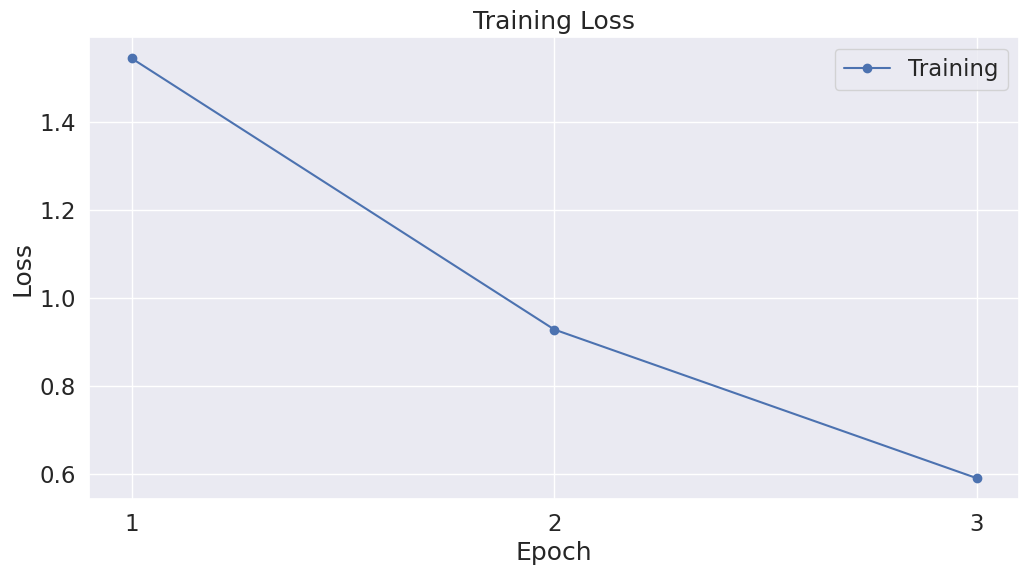

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

df_stats = pd.read_parquet(f"{output_dir}/training_stats.parquet")

sns.set(style='darkgrid')

sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

plt.plot(df_stats['Training Loss'], 'b-o', label="Training")

plt.title("Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.xticks([1, 2, 3])

plt.show()

12. Load and test the model.

In [ ]:
from transformers import AutoTokenizer, AutoModelForCausalLM
import torch

project = "Aira-2-1B1"

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

tokenizer = AutoTokenizer.from_pretrained('nicholasKluge/Aira-2-1B1')
aira = AutoModelForCausalLM.from_pretrained('nicholasKluge/Aira-2-1B1')

aira.eval()
aira.to(device)

question =  input("Enter your question: ")

inputs = tokenizer(tokenizer.bos_token + question + tokenizer.sep_token, return_tensors="pt").to(device)

responses = aira.generate(**inputs,
    bos_token_id=tokenizer.bos_token_id,
    pad_token_id=tokenizer.pad_token_id,
    eos_token_id=tokenizer.eos_token_id,
    do_sample=True,
    top_k=50,
    max_length=500,
    top_p=0.95,
    temperature=0.7,
    num_return_sequences=2)

print(f"Question: 👤 {question}\n")

for i, response in  enumerate(responses):
    print(f'Response {i+1}: 🤖 {tokenizer.decode(response, skip_special_tokens=True).replace(question, "")}')


Done! 🤗